# FT-Transformer Training for Dry Bean Classification

This notebook implements the **FT-Transformer (Feature Tokenizer + Transformer)** architecture for tabular data classification on the Dry Bean dataset using the `rtdl` library.

## FT-Transformer Overview

The FT-Transformer is a Transformer-based architecture specifically designed for tabular data that:
- Converts numerical and categorical features into embeddings
- Uses attention mechanisms to capture feature interactions
- Applies layer normalization and residual connections
- Provides state-of-the-art performance on many tabular datasets

## Implementation Details

- **Feature Tokenization**: Each feature is converted to a token embedding
- **Positional Encoding**: Features get positional information
- **Multi-Head Attention**: Captures complex feature interactions
- **Feed-Forward Networks**: Non-linear transformations
- **Classification Head**: Final prediction layer

**Reference**: Gorishniy, Y., Rubachev, I., Khrulkov, V., & Babenko, A. (2021). Revisiting Deep Learning Models for Tabular Data. arXiv preprint arXiv:2106.11959.

In [15]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

# PyTorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset

# ML libraries
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_recall_fscore_support, roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score
)

# Import rtdl library for FT-Transformer
try:
    import rtdl
    print("✅ rtdl library imported successfully")
    print(f"rtdl version: {rtdl.__version__ if hasattr(rtdl, '__version__') else 'unknown'}")
except ImportError:
    print("❌ rtdl library not available. Install with: pip install rtdl")
    print("This notebook requires the rtdl library to run.")
    raise ImportError("Please install rtdl: pip install rtdl")

# Import our custom evaluation framework
try:
    from enhanced_evaluation import ComprehensiveEvaluator
    print("✅ Enhanced evaluation imported successfully")
except ImportError:
    print("⚠️ Enhanced evaluation not available. Using basic evaluation.")
    ComprehensiveEvaluator = None

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

print("🤖 FT-Transformer Training for Dry Bean Classification")
print("Dataset: Dry Bean Classification")

✅ rtdl library imported successfully
rtdl version: 0.0.13
✅ Enhanced evaluation imported successfully
Using device: cuda
🤖 FT-Transformer Training for Dry Bean Classification
Dataset: Dry Bean Classification


## Load Preprocessed Data

In [16]:
# Load preprocessed data from Section 1
import pickle

try:
    with open('dry_bean_preprocessed_data.pkl', 'rb') as f:
        preprocessing_data = pickle.load(f)
    
    # Extract variables
    X_train_scaled = preprocessing_data['X_train_scaled']
    X_val_scaled = preprocessing_data['X_val_scaled']
    X_test_scaled = preprocessing_data['X_test_scaled']
    y_train = preprocessing_data['y_train']
    y_val = preprocessing_data['y_val']
    y_test = preprocessing_data['y_test']
    feature_names = preprocessing_data['feature_names']
    class_mapping = preprocessing_data['class_mapping']
    label_encoder = preprocessing_data['label_encoder']
    data_summary = preprocessing_data['data_summary']
    
    print("✅ Preprocessed data loaded successfully!")
    print(f"Training set: {X_train_scaled.shape}")
    print(f"Validation set: {X_val_scaled.shape}")
    print(f"Test set: {X_test_scaled.shape}")
    print(f"Features: {len(feature_names)}")
    print(f"Classes: {len(class_mapping)}")
    print(f"Class names: {list(class_mapping.keys())}")

    # After loading your preprocessed data, before moving to GPU
    print("Checking for invalid values...")
    print(f"NaN in X_train: {np.isnan(X_train_scaled).any()}")
    print(f"Inf in X_train: {np.isinf(X_train_scaled).any()}")
    print(f"NaN in y_train: {np.isnan(y_train).any()}")

    # Check data ranges
    print(f"X_train min: {X_train_scaled.min()}, max: {X_train_scaled.max()}")
    print(f"y_train min: {y_train.min()}, max: {y_train.max()}")

    
except FileNotFoundError:
    print("❌ Preprocessed data not found!")
    print("Please run Section 1 (Data Preprocessing) notebook first.")
    raise

# After loading preprocessed data, before tensor creation
import gc

# Clean up any existing GPU memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.synchronize()

# Force garbage collection
gc.collect()

# Check GPU memory
if torch.cuda.is_available():
    print(f"GPU memory allocated: {torch.cuda.memory_allocated()/1024**2:.2f} MB")
    print(f"GPU memory cached: {torch.cuda.memory_reserved()/1024**2:.2f} MB")


# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
X_val_tensor = torch.FloatTensor(X_val_scaled).to(device)
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
y_train_tensor = torch.LongTensor(y_train).to(device)
y_val_tensor = torch.LongTensor(y_val).to(device)
y_test_tensor = torch.LongTensor(y_test).to(device)

print(f"\n📊 Data converted to PyTorch tensors on {device}")
print(f"Input features: {X_train_tensor.shape[1]}")
print(f"Number of classes: {len(class_mapping)}")

# Get class names for visualization
class_names = list(class_mapping.keys())
n_features = X_train_tensor.shape[1]
n_classes = len(class_mapping)

✅ Preprocessed data loaded successfully!
Training set: (8710, 16)
Validation set: (2178, 16)
Test set: (2723, 16)
Features: 16
Classes: 7
Class names: ['BARBUNYA', 'BOMBAY', 'CALI', 'DERMASON', 'HOROZ', 'SEKER', 'SIRA']
Checking for invalid values...
NaN in X_train: False
Inf in X_train: False
NaN in y_train: False
X_train min: -14.328765909875251, max: 6.640651046823079
y_train min: 0, max: 6
GPU memory allocated: 30.94 MB
GPU memory cached: 56.00 MB

📊 Data converted to PyTorch tensors on cuda
Input features: 16
Number of classes: 7


## Data Preparation for FT-Transformer

In [17]:
# Prepare data for FT-Transformer
# FT-Transformer expects specific data format with feature information

# Since all features are numerical (after preprocessing), we treat them as continuous
# Create feature info for rtdl
feature_info = {
    'n_num_features': n_features,  # All features are numerical
    'n_cat_features': 0,           # No categorical features after preprocessing
    'cat_cardinalities': []        # Empty since no categorical features
}

print(f"📋 Feature Information:")
print(f"   Numerical features: {feature_info['n_num_features']}")
print(f"   Categorical features: {feature_info['n_cat_features']}")
print(f"   Feature names: {feature_names[:5]}... (showing first 5)")

# Create data loaders
batch_size = 256

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"\n🔄 Data loaders created:")
print(f"   Batch size: {batch_size}")
print(f"   Train batches: {len(train_loader)}")
print(f"   Validation batches: {len(val_loader)}")
print(f"   Test batches: {len(test_loader)}")

📋 Feature Information:
   Numerical features: 16
   Categorical features: 0
   Feature names: ['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength', 'AspectRatio']... (showing first 5)

🔄 Data loaders created:
   Batch size: 256
   Train batches: 35
   Validation batches: 9
   Test batches: 11


## FT-Transformer Model Configuration

In [18]:
# FT-Transformer hyperparameters

# Training hyperparameters
training_config = {
    'learning_rate': 1e-4,
    'weight_decay': 1e-5,
    'n_epochs': 100,
    'patience': 15,  # Early stopping patience
    'min_delta': 1e-4  # Minimum improvement for early stopping
}

print("\n📚 Training Configuration:")
for key, value in training_config.items():
    print(f"   {key}: {value}")


📚 Training Configuration:
   learning_rate: 0.0001
   weight_decay: 1e-05
   n_epochs: 100
   patience: 15
   min_delta: 0.0001


## FT-Transformer Model Creation

In [19]:
# Create FT-Transformer using rtdl library
print("🤖 Creating FT-Transformer using rtdl library...")

model = rtdl.FTTransformer.make_default(
    n_num_features=feature_info['n_num_features'],
    cat_cardinalities=feature_info['cat_cardinalities'],
d_out=n_classes
)

# Move model to device
model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n📊 Model Statistics:")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")
print(f"   Model size: ~{total_params * 4 / 1024 / 1024:.2f} MB")

🤖 Creating FT-Transformer using rtdl library...

📊 Model Statistics:
   Total parameters: 899,143
   Trainable parameters: 899,143
   Model size: ~3.43 MB


## Training Setup

In [20]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    model.parameters(), 
    lr=training_config['learning_rate'],
    weight_decay=training_config['weight_decay']
)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=10
)

print("🔧 Training setup completed:")
print(f"   Loss function: CrossEntropyLoss")
print(f"   Optimizer: AdamW (lr={training_config['learning_rate']}, wd={training_config['weight_decay']})")
print(f"   Scheduler: ReduceLROnPlateau")

# Training history
history = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': [],
    'learning_rates': []
}

# Early stopping
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

🔧 Training setup completed:
   Loss function: CrossEntropyLoss
   Optimizer: AdamW (lr=0.0001, wd=1e-05)
   Scheduler: ReduceLROnPlateau


## Training Functions

In [21]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train the model for one epoch"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        
        # For rtdl FTTransformer, we need to pass data in the expected format
        # Since we only have numerical features, we pass None for categorical
        output = model(data, None)  # (numerical_features, categorical_features)
        
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)
    
    avg_loss = total_loss / len(train_loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

def validate_epoch(model, val_loader, criterion, device):
    """Validate the model for one epoch"""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            
            # For rtdl FTTransformer, we need to pass data in the expected format
            output = model(data, None)  # (numerical_features, categorical_features)
            
            loss = criterion(output, target)
            
            total_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)
    
    avg_loss = total_loss / len(val_loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

print("✅ Training functions defined")

✅ Training functions defined


## Training Loop

In [22]:
print("🚀 Starting FT-Transformer training...")
print(f"Training for {training_config['n_epochs']} epochs with early stopping (patience={training_config['patience']})")
print("-" * 80)

start_time = time.time()

for epoch in range(training_config['n_epochs']):
    # Training
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validation
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    
    # Store history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    history['learning_rates'].append(current_lr)
    
    # Early stopping check
    if val_loss < best_val_loss - training_config['min_delta']:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = model.state_dict().copy()
        best_epoch = epoch
    else:
        patience_counter += 1
    
    # Print progress
    if (epoch + 1) % 10 == 0 or epoch < 5:
        print(f"Epoch {epoch+1:3d}/{training_config['n_epochs']} | "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | "
              f"LR: {current_lr:.2e} | Patience: {patience_counter}/{training_config['patience']}")
    
    # Early stopping
    if patience_counter >= training_config['patience']:
        print(f"\n⏹️ Early stopping triggered at epoch {epoch+1}")
        print(f"Best validation loss: {best_val_loss:.4f} at epoch {best_epoch+1}")
        break

training_time = time.time() - start_time

# Load best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"\n✅ Loaded best model from epoch {best_epoch+1}")

print(f"\n🏁 Training completed in {training_time:.2f} seconds")
print(f"Best validation loss: {best_val_loss:.4f}")
print(f"Final validation accuracy: {history['val_acc'][best_epoch]:.2f}%")

🚀 Starting FT-Transformer training...
Training for 100 epochs with early stopping (patience=15)
--------------------------------------------------------------------------------
Epoch   1/100 | Train Loss: 0.9240 | Train Acc: 73.26% | Val Loss: 0.3916 | Val Acc: 92.10% | LR: 1.00e-04 | Patience: 0/15
Epoch   2/100 | Train Loss: 0.3781 | Train Acc: 90.82% | Val Loss: 0.2633 | Val Acc: 93.16% | LR: 1.00e-04 | Patience: 0/15
Epoch   3/100 | Train Loss: 0.2815 | Train Acc: 92.10% | Val Loss: 0.2371 | Val Acc: 92.84% | LR: 1.00e-04 | Patience: 0/15
Epoch   4/100 | Train Loss: 0.2602 | Train Acc: 92.32% | Val Loss: 0.2361 | Val Acc: 92.65% | LR: 1.00e-04 | Patience: 0/15
Epoch   5/100 | Train Loss: 0.2492 | Train Acc: 91.80% | Val Loss: 0.2145 | Val Acc: 93.16% | LR: 1.00e-04 | Patience: 0/15
Epoch  10/100 | Train Loss: 0.2043 | Train Acc: 93.08% | Val Loss: 0.2091 | Val Acc: 92.93% | LR: 1.00e-04 | Patience: 1/15
Epoch  20/100 | Train Loss: 0.1940 | Train Acc: 93.46% | Val Loss: 0.2009 | Val

## Training Visualization

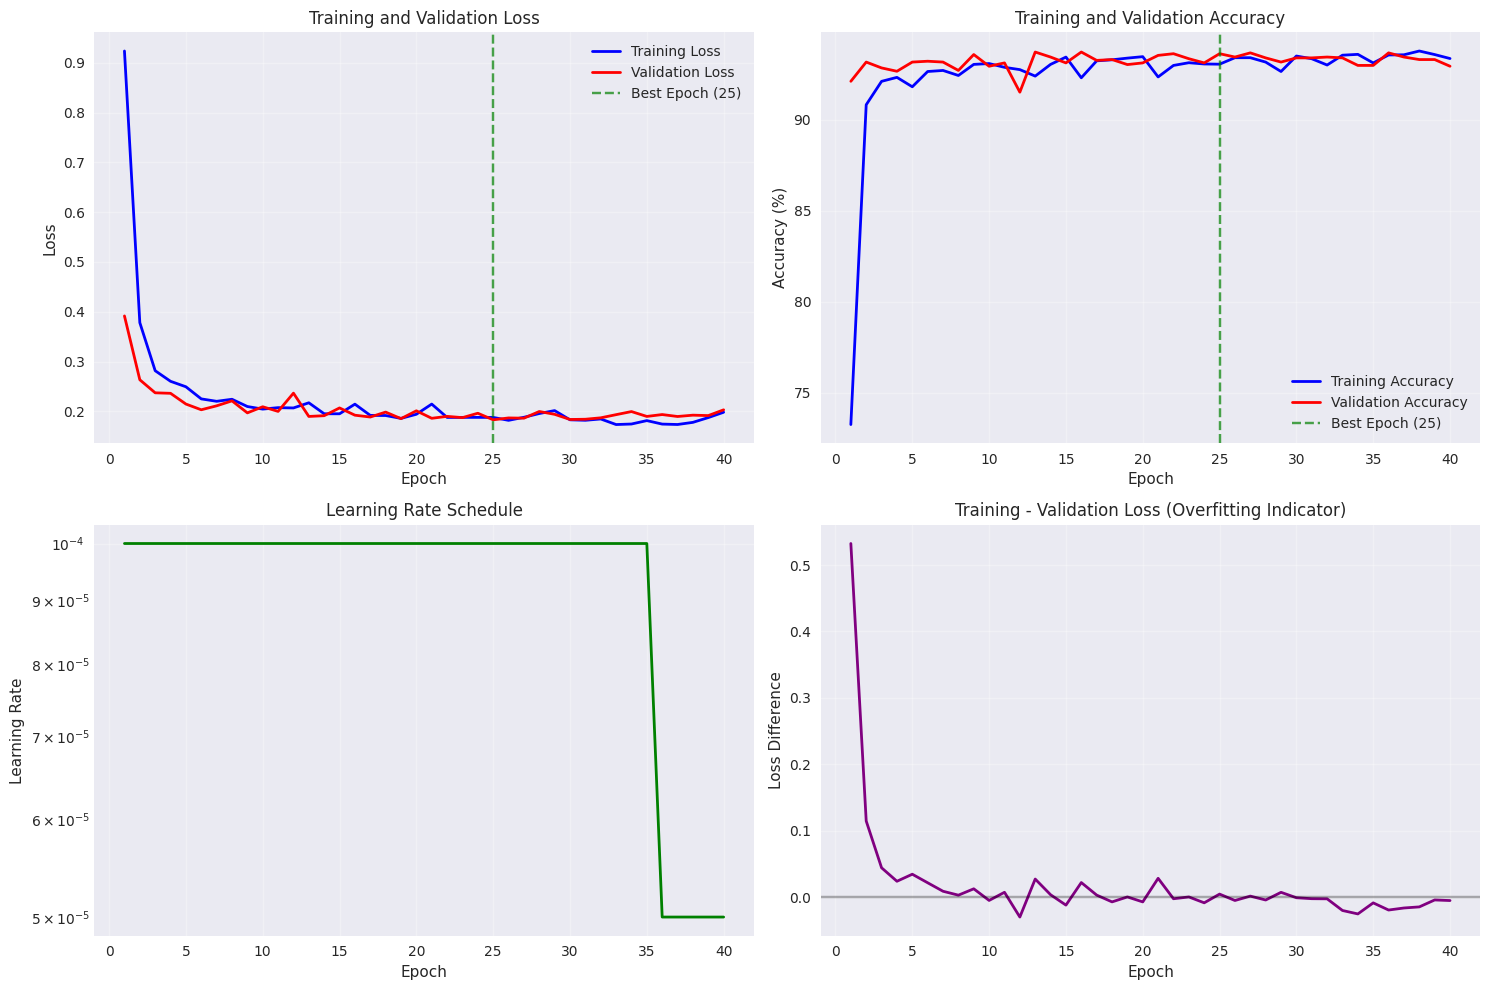


📈 Training Summary:
   Total epochs: 40
   Best epoch: 25
   Best validation loss: 0.1828
   Training time: 24.33 seconds
   Final learning rate: 5.00e-05


<Figure size 800x550 with 0 Axes>

In [23]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

epochs = range(1, len(history['train_loss']) + 1)

# Loss curves
axes[0, 0].plot(epochs, history['train_loss'], 'b-', label='Training Loss', linewidth=2)
axes[0, 0].plot(epochs, history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
axes[0, 0].axvline(x=best_epoch+1, color='g', linestyle='--', alpha=0.7, label=f'Best Epoch ({best_epoch+1})')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy curves
axes[0, 1].plot(epochs, history['train_acc'], 'b-', label='Training Accuracy', linewidth=2)
axes[0, 1].plot(epochs, history['val_acc'], 'r-', label='Validation Accuracy', linewidth=2)
axes[0, 1].axvline(x=best_epoch+1, color='g', linestyle='--', alpha=0.7, label=f'Best Epoch ({best_epoch+1})')
axes[0, 1].set_title('Training and Validation Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Learning rate schedule
axes[1, 0].plot(epochs, history['learning_rates'], 'g-', linewidth=2)
axes[1, 0].set_title('Learning Rate Schedule')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Learning Rate')
axes[1, 0].set_yscale('log')
axes[1, 0].grid(True, alpha=0.3)

# Loss difference (overfitting indicator)
loss_diff = np.array(history['train_loss']) - np.array(history['val_loss'])
axes[1, 1].plot(epochs, loss_diff, 'purple', linewidth=2)
axes[1, 1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[1, 1].set_title('Training - Validation Loss (Overfitting Indicator)')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss Difference')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.savefig(f'Dry_bean_FtTransformer_Training - Validation Loss (Overfitting Indicator)')

print(f"\n📈 Training Summary:")
print(f"   Total epochs: {len(history['train_loss'])}")
print(f"   Best epoch: {best_epoch+1}")
print(f"   Best validation loss: {best_val_loss:.4f}")
print(f"   Training time: {training_time:.2f} seconds")
print(f"   Final learning rate: {history['learning_rates'][-1]:.2e}")

## Initialize Enhanced Evaluator

In [24]:

# Initialize the comprehensive evaluator
evaluator = ComprehensiveEvaluator()

# Create PyTorch model wrapper for the FT-Transformer
ft_wrapper = evaluator.create_pytorch_wrapper(
    model=model,
    device=device,
    batch_size=256
)

print("✅ Enhanced evaluator initialized")
print("✅ FT-Transformer wrapper created")
print(f"   Device: {device}")
print(f"   Batch size: 256")

✅ Enhanced evaluator initialized
✅ FT-Transformer wrapper created
   Device: cuda
   Batch size: 256


## Comprehensive Model Evaluation

This section performs a complete evaluation of the FT-Transformer model using the enhanced evaluation framework.

🚀 Starting comprehensive FT-Transformer evaluation...
This may take a few minutes depending on your hardware.

Evaluating FT-Transformer

📊 Performance Metrics:
   Accuracy: 0.9251
   Balanced Accuracy: 0.9341
   Precision: 0.9260
   Recall: 0.9251
   F1-Score: 0.9253
   Matthews Correlation: 0.9094
   AUC-ROC: 0.9938
   Log Loss: 0.2130

⏱️  Timing:
   Training Time: 0.0000s
   Inference Time: 0.0471s
   Predictions/sec: 57776


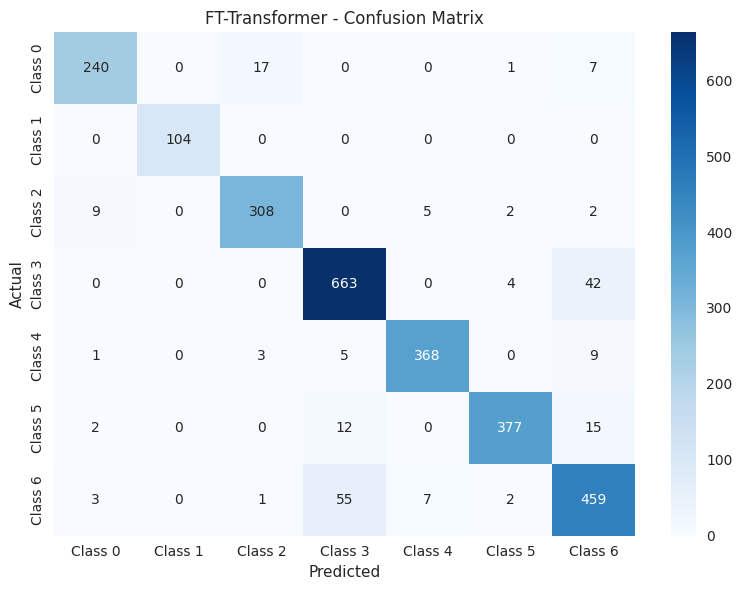

<Figure size 800x550 with 0 Axes>

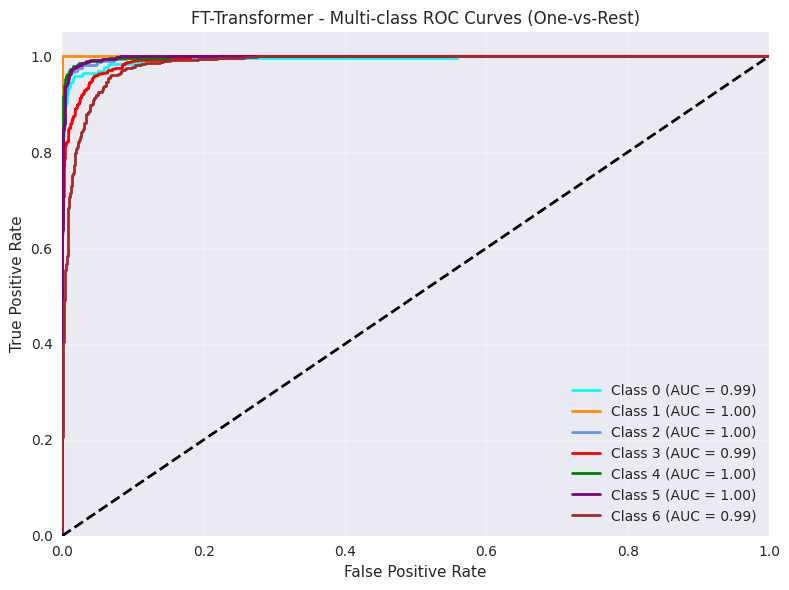

Skipping Precision-Recall curve for FT-Transformer (multi-class not supported)
Skipping calibration curve for FT-Transformer (multi-class not supported)

✅ FT-Transformer evaluation completed!


<Figure size 800x550 with 0 Axes>

In [25]:
# Perform comprehensive evaluation
print("🚀 Starting comprehensive FT-Transformer evaluation...")
print("This may take a few minutes depending on your hardware.")

# Evaluate the FT-Transformer model
ft_results = evaluator.evaluate_model(
    model=ft_wrapper,
    model_name="FT-Transformer",
    X_train=X_train_scaled,
    X_test=X_test_scaled,
    y_train=y_train,
    y_test=y_test,
    X_val=X_val_scaled,
    y_val=y_val,
    predict_proba_available=True
)

print("\n✅ FT-Transformer evaluation completed!")

## Detailed Results Analysis

In [12]:
# Display detailed results
print("📊 DETAILED FT-TRANSFORMER RESULTS")
print("=" * 60)

# Create results DataFrame for better visualization
results_df = pd.DataFrame([ft_results]).T
results_df.columns = ['FT-Transformer']

# Performance metrics
performance_metrics = ['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1', 'mcc']
if 'auc_roc' in results_df.index:
    performance_metrics.append('auc_roc')
if 'log_loss' in results_df.index:
    performance_metrics.append('log_loss')

print("\n🎯 Performance Metrics:")
performance_df = results_df.loc[performance_metrics]
for metric in performance_metrics:
    if metric in results_df.index:
        value = results_df.loc[metric, 'FT-Transformer']
        print(f"   {metric.replace('_', ' ').title()}: {value:.4f}")

# Timing metrics
timing_metrics = ['train_time', 'inference_time', 'predictions_per_second']
print("\n⏱️ Timing Metrics:")
for metric in timing_metrics:
    if metric in results_df.index:
        value = results_df.loc[metric, 'FT-Transformer']
        if metric == 'predictions_per_second':
            print(f"   {metric.replace('_', ' ').title()}: {value:.0f}")
        else:
            print(f"   {metric.replace('_', ' ').title()}: {value:.4f}s")

# Cross-validation metrics (if available)
if 'cv_f1_mean' in results_df.index:
    print("\n🔄 Cross-Validation:")
    cv_mean = results_df.loc['cv_f1_mean', 'FT-Transformer']
    cv_std = results_df.loc['cv_f1_std', 'FT-Transformer']
    print(f"   F1 Score: {cv_mean:.4f} ± {cv_std:.4f}")

📊 DETAILED FT-TRANSFORMER RESULTS

🎯 Performance Metrics:
   Accuracy: 0.9251
   Balanced Accuracy: 0.9341
   Precision: 0.9260
   Recall: 0.9251
   F1: 0.9253
   Mcc: 0.9094
   Auc Roc: 0.9938
   Log Loss: 0.2130

⏱️ Timing Metrics:
   Train Time: 0.0000s
   Inference Time: 0.2969s
   Predictions Per Second: 9171


## Model Performance Summary

In [13]:
# Create a comprehensive summary
print("📈 FT-TRANSFORMER PERFORMANCE SUMMARY")
print("=" * 50)

# Get predictions for additional analysis
y_pred = ft_wrapper.predict(X_test_scaled)
y_proba = ft_wrapper.predict_proba(X_test_scaled)

# Per-class analysis
from sklearn.metrics import precision_recall_fscore_support, classification_report

precision_per_class, recall_per_class, f1_per_class, support_per_class = precision_recall_fscore_support(
    y_test, y_pred, average=None
)

print("\n📋 Per-Class Performance:")
print("-" * 70)
print(f"{'Class':<15} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Support':<10}")
print("-" * 70)

for i, class_name in enumerate(class_names):
    print(f"{class_name:<15} {precision_per_class[i]:<10.4f} "
          f"{recall_per_class[i]:<10.4f} {f1_per_class[i]:<10.4f} "
          f"{support_per_class[i]:<10.0f}")

# Model strengths and weaknesses
best_class_idx = np.argmax(f1_per_class)
worst_class_idx = np.argmin(f1_per_class)

print(f"\n🏆 Best performing class: {class_names[best_class_idx]} (F1: {f1_per_class[best_class_idx]:.4f})")
print(f"⚠️ Worst performing class: {class_names[worst_class_idx]} (F1: {f1_per_class[worst_class_idx]:.4f})")

# Overall assessment
overall_accuracy = ft_results['accuracy']
overall_f1 = ft_results['f1']

print(f"\n🎯 Overall Assessment:")
if overall_accuracy > 0.9:
    print(f"   Excellent performance (Accuracy: {overall_accuracy:.4f})")
elif overall_accuracy > 0.8:
    print(f"   Good performance (Accuracy: {overall_accuracy:.4f})")
elif overall_accuracy > 0.7:
    print(f"   Moderate performance (Accuracy: {overall_accuracy:.4f})")
else:
    print(f"   Needs improvement (Accuracy: {overall_accuracy:.4f})")

print(f"   Weighted F1-Score: {overall_f1:.4f}")
print(f"   Model complexity: {total_params:,} parameters")
print(f"   Inference speed: {ft_results['predictions_per_second']:.0f} predictions/second")

📈 FT-TRANSFORMER PERFORMANCE SUMMARY

📋 Per-Class Performance:
----------------------------------------------------------------------
Class           Precision  Recall     F1-Score   Support   
----------------------------------------------------------------------
BARBUNYA        0.9412     0.9057     0.9231     265       
BOMBAY          1.0000     1.0000     1.0000     104       
CALI            0.9362     0.9448     0.9405     326       
DERMASON        0.9020     0.9351     0.9183     709       
HOROZ           0.9684     0.9534     0.9608     386       
SEKER           0.9767     0.9286     0.9520     406       
SIRA            0.8596     0.8710     0.8652     527       

🏆 Best performing class: BOMBAY (F1: 1.0000)
⚠️ Worst performing class: SIRA (F1: 0.8652)

🎯 Overall Assessment:
   Excellent performance (Accuracy: 0.9251)
   Weighted F1-Score: 0.9253
   Model complexity: 899,143 parameters
   Inference speed: 9171 predictions/second


## Save Evaluation Results

In [14]:
# Save evaluation results
print("💾 Saving evaluation results...")

# Save detailed results
results_df.to_csv('ft_transformer_evaluation_results.csv')
print("✅ Detailed results saved to 'ft_transformer_evaluation_results.csv'")

# Save per-class results
per_class_results = pd.DataFrame({
    'Class': class_names,
    'Precision': precision_per_class,
    'Recall': recall_per_class,
    'F1-Score': f1_per_class,
    'Support': support_per_class
})
per_class_results.to_csv('ft_transformer_per_class_results.csv', index=False)
print("✅ Per-class results saved to 'ft_transformer_per_class_results.csv'")

# Save predictions for further analysis
predictions_df = pd.DataFrame({
    'true_labels': y_test,
    'predicted_labels': y_pred,
    'max_probability': np.max(y_proba, axis=1)
})

# Add probability columns for each class
for i, class_name in enumerate(class_names):
    predictions_df[f'prob_{class_name}'] = y_proba[:, i]

predictions_df.to_csv('ft_transformer_predictions.csv', index=False)
print("✅ Predictions saved to 'ft_transformer_predictions.csv'")

print("\n🎉 FT-Transformer evaluation completed successfully!")
print("\n📁 Generated files:")
print("   - ft_transformer_evaluation_results.csv")
print("   - ft_transformer_per_class_results.csv")
print("   - ft_transformer_predictions.csv")
print("   - FT-Transformer_confusion_matrix.png")
print("   - FT-Transformer_roc_curve.png (if applicable)")

💾 Saving evaluation results...
✅ Detailed results saved to 'ft_transformer_evaluation_results.csv'
✅ Per-class results saved to 'ft_transformer_per_class_results.csv'
✅ Predictions saved to 'ft_transformer_predictions.csv'

🎉 FT-Transformer evaluation completed successfully!

📁 Generated files:
   - ft_transformer_evaluation_results.csv
   - ft_transformer_per_class_results.csv
   - ft_transformer_predictions.csv
   - FT-Transformer_confusion_matrix.png
   - FT-Transformer_roc_curve.png (if applicable)
